In [1]:
from tqdm.notebook import tqdm

In [15]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1,
                 teff_extrap_limit=100,debug=False):
        
        '''
        Inputs:
        ------
                         teff: 2x1 array-like
                               Teff and error of star

                         logg: 2x1 array-like
                               Log(g) and error of star

                        abund: 2x2 array-like
                               first column is [M/H] and [Alpha/M] and the second 
                               column is the errors

                     obs_phot: 6x2 array-like
                               first column is BP, G, RP, J, H, and K and the second 
                               column is the errors

                     distance: float
                               distance to star in pc
                    
                   isochrones: astropy Table 
                               PARSEC isochrone table
                        
                      ext_law: string, optional
                               extinction law to use. Default is CCM89.

                               Available Extinction Laws: 
                               -------------------------

                               CCM89 - Cardelli, Clayton, & Mathis 1989
                               O94 - O'Donnell 1994
                               F99 - Fitzpatrick 1999
                               F04 - Fitzpatrick 2004
                               VCG04 - Valencic, Clayton, & Gordon 2004
                               GCC09 - Grodon, Cartledge, & Clayton 2009
                               M14 - Maiz Apellaniz et al 2014
                               F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                               D22 - Decleir et al. 2022
                        
                           rv: float, optional
                               Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                               (required to be 3.1 if ext_law = 'F99')
                        
            teff_extrap_limit: float
                               limit for maximum allowable temperature outside 
                               isochrone range
                        
                        debug: boolean
                               print useful information to the screen

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris corrected [Fe/H]
        corrected_met = self.salaris_corrected_metallicity([abund[0,0],abund[0,1]],[abund[1,0],abund[1,1]])
        self.salfeh,self.salfeh_err = corrected_met[0],corrected_met[1]
        
        # observed photometry
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
#         if np.size(np.where(np.isfinite(test)==False))>0:
#             print('')
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Extinction
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K (microns)
        self.extlaw_coeff = self.extcoeff(law=ext_law)
        
        # Other
        self.debug = debug
        self.teff_extrap_limit = teff_extrap_limit 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value.

        Inputs:
        ------
             data: array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value.

        Inputs:
        ------
              data: array-like
                    data to search through

             value: float or int
                    value of interest

        Output:     
        ------     
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ###################
    ### Metallicity ###
    ###################
    
    def salaris_corrected_metallicity(self,metal,alpha):
        '''
        Calculate the Salaris corrected metallicity (Salaris et al. 1993) using updated solar 
        parameters from Asplund et al. 2021.
        
        Inputs:
        ------
                  metal: 2x1 array-like
                         either [Fe/H] or [M/H] with associated error
                     
                  alpha: 2x1 array-like
                         alpha abundance (either [alpha/Fe] or [alpha/M] corresponding to metal) 
                         with associate error 
                     
        Outputs:
        -------
                salfeh:  float
                         Salaris corrected metallicity
            
            salfeh_err:  float
                         error in Salaris corrected metallicity
            
        '''
        salfeh = metal[0]+np.log10(0.659*(10**alpha[0])+0.341)
        salfeh_err = np.sqrt(metal[1]**2+(10**alpha[0]/(0.517372+10**alpha[0])*alpha[1])**2)
        
        return salfeh, salfeh_err
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,rv=3.1,law='CCM89'):

        '''
        Calculate the relative extincion law coefficients for the BP, G, RP, J, H, Ks bands
        for a given Rv and extinction law.

        Input:
        -----
                    rv: float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
                        
                   law: str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
        Output:
        ------
             ext_coeff: float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and Ks bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
        '''
        
        if self.debug:
            print('### Running Aetas.extinction() ###')
            print('Inputs from Aetas.__init__()')
            print('Salaris Corrected Metallicity:',self.salfeh)
            print('Temperature:',self.teff)

        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure there are enough isochrone points
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        if self.debug:
            print('Calculated Observed Colors:')
            print('Observed Colors:',obs_colors)
            print('Observed Color Errors:',obs_colors_err)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        # relative extinction vector
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        iso_colors = 999999.0*np.ones(5)
        iso_colors_deriv = 999999.0*np.ones(5)
        
        # determine if the Teff is in the isochrone range
        use_lgteff = np.log10(self.teff)
        if use_lgteff < np.min(iso_['logTe']) or use_lgteff > np.max(iso_['logTe']):
            use_lgteff = closest(iso_['logTe'],np.log10(self.teff))
        
        # Interpolate the color-Teff relation using a b-spline
        logTe = iso_['logTe']
        for i in range(5):
            try:
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])

                bspl = bspline(logTe,color)
                iso_colors[i] = bspl(use_lgteff)
                iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    iso_colors[i] = bspl(use_lgteff)
                    iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
                except:
                    iso_colors[i] = 999999.0
                    iso_colors_deriv[i] = 999999.0
                    
        if self.debug:
            print('Isochrone Colors:',iso_colors)
                
        # calculate the extinctions and errors
        color_diff = obs_colors-iso_colors
        color_errs = np.abs((iso_colors_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+color_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            if self.debug:
                print('All Colors are bad')
                print('Max Iso Teff:',10**np.nanmax(iso_['logTe']))
                print('Min Iso Teff:',10**np.nanmin(iso_['logTe']))
                print('Obs Teff:',self.teff)
            
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        # chisq
        iso_colors_extincted = iso_colors+red_vec*ag
        ext_chi = sum((obs_colors-iso_colors_extincted)**2/obs_colors_err**2)
        
        self.ext = ext
        
        if self.debug:
            print('A(G)+ Error:',ag,ag_err)
            print('All Extinctions:',ext[:,0])
            print('chisq:',ext_chi)
            print('resid:',obs_colors-iso_colors_extincted)
        
        return ext
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,age):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
                teff: float
                      Teff of star 
                      
                 age: float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        if self.debug:
            print('Running Aetas.teff_2_appmags()')
            print('Teff:',teff)
            print('Extinctions:',extincts)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            

            ### Teff check
            extrap = False

            if (10**min(iso_['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_['logTe']) > self.teff_extrap_limit):
                if debug:
                    print('Teff Oustide extrapolation limit')
                    print('Age',age)
                    print('max iso',max(iso_['logTe']))
                    print('min iso',min(iso_['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                extrap = True
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap:
                    mag_spl = interp(iso_['logTe'],iso_[self.labels[i]],lgteff,
                                     assume_sorted=False,extrapolate=True)
                else:
                    mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap:
                lgg_spl = interp(iso_['logTe'],iso_['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            
            calc_logg = lgg_spl(lgteff)
            
            self.calc_logg = calc_logg
                
            return np.array(calc_mags, calc_logg)
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if self.debug:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            
            extrap_lo = False
            extrap_hi = False
            did_extrap = 0
            
            if (10**min(iso_lo['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_lo['logTe']) > self.teff_extrap_limit):
            
                if self.debug:
                    print('outside iso_lo')
                    print('Age',10**lgage_lo/10**9)
                    print('max iso_lo',max(iso_lo['logTe']))
                    print('min iso_lo',min(iso_lo['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if (10**min(iso_hi['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_hi['logTe']) > self.teff_extrap_limit):
                if self.debug:
                    print('outside iso_hi')
                    print('max iso_hi',max(iso_hi['logTe']))
                    print('min iso_hi',min(iso_hi['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_hi['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                extrap_lo = True
                did_extrap = 1
                
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                extrap_hi = True   
                did_extrap = 1
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap_lo:
                    mag_spl_lo = interp(iso_lo['logTe'],iso_lo[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]])(lgteff)
                    
                if extrap_hi:
                    mag_spl_hi = interp(iso_hi['logTe'],iso_hi[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])(lgteff)
                 
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[mag_spl_lo,mag_spl_hi],1)))
                self.age_spl_interp_deriv = age_spl_interp.deriv()
                
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap_lo:
                lgg_spl_lo = interp(iso_lo['logTe'],iso_lo['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])(lgteff)
                
            if extrap_hi:
                lgg_spl_hi = interp(iso_hi['logTe'],iso_hi['logg'],lgteff,assume_sorted=False,extrapolate=True)
            
            else:
                lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])(lgteff)
            
            lgg_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[lgg_spl_lo,lgg_spl_hi],1)))
            
            calc_logg = lgg_spl_interp(age)
            
            self.calc_logg = calc_logg
            
            self.did_extrap = did_extrap
            
            return np.append(calc_mags, calc_logg)
        
    #######################
    ### Ages and Masses ###
    #######################
    
    def isochrone_check(self,flags=False,filename=None):
        '''
        Diagnostic to check if a star falls on isochrones or not. 
        
        Input:
        -----
               flags: boolean
                      if True return flags stating if the star falls on the isochrones.
                      prints a flag for Teff, log(g)
        
            filename: str (optional)
                      filename without extension
        '''
        
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        colorteff_labels = np.array(['BP - G','G - RP','G - J','G - H','G - Ks'])
        
        # get colors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
#         obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        ### Spectroscopic HR diagram
        plt.figure(figsize=[12,10])
        plt.scatter(10**self.iso['logTe'],self.iso['logg'],
                    c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
        plt.colorbar()
        plt.scatter(self.teff,self.logg)
        
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        plt.xlabel(r'Teff')
        plt.ylabel(r'Log(g)')
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()
        
        ### Color Teff relationships
        fig,ax = plt.subplots(figsize=[72,10])
        
        for i in range(5):
            color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
            im = ax[i].scatter(10**self.iso['logTe'],color,c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
            ax[i].scatter(self.teff,obs_colors[i],marker='*',s=500)
            
            ax[i].set_xlabel(r'Teff')
            ax[i].set_ylabel(r'{}'.format(colorteff_labels[i]))
        
        fig.colorbar(im, ax=ax.ravel().tolist())
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()

    def get_age(self,guess_ages=np.linspace(0.012,17.)[::10]):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
                   age: float 
                        best age according to chi^2 space search
                        
                   chi: float
                        best chi^2 according to chi^2 space search
                        
                   rms: float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []
        
        # set photometry error or 0.01 if tiny
        phot_err = np.maximum(self.phot_err,0.01)
        
        if self.debug:
            print('Running Aetas.get_age()')
            print('guess_ages:',guess_ages)

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            try:
                # calculate best fit parameters and covariance matrix
                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(phot_err,self.logg_err)


                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_ages[j],
                                      method='lm',sigma=obs_quants_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

                if self.debug:
                    print('Calc App Mags + logg:',curve_mags_logg)
                    print('Observed Mags + logg:',obs_quants)
                    print('Observed Mags + logg Errors:',obs_quants_err)
                    

                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.std(curve_mags_logg-obs_quants))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
                
                
            if self.debug:
                print(j+1,guess_ages[j],curve_ages[j],curve_chi[j],curve_rms[j])
                
        if np.sum(np.array(curve_ages)<1e5)==0:
            if self.debug:
                print('All Bad')
            return 999999.0, 999999.0, 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms
        
        if self.debug:
            print('Best Fit Age, chi, RMS:',self.age,self.chi,self.rms)

        return age, chi, rms
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''
        
        if age == 999999.0:
            return 999999.0
        
        if self.debug:
            print('Running Aetas.age_2_mass()')
            print('Age:',age)
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            if self.debug:
                print('Not enough isochrone points')
            return 999999.0
        
        try:
            ### calculate the mass using a B-spline
            bspl = bspline(iso_['logAge'],iso_['Mass'])
            mass = bspl(np.log10(age*10**9))
            
        except:
            try:
                # try to extrapolate
                bspl = bspline(iso_['logAge'],iso_['Mass'],extrapolate=True)
                mass = 999999.0

            except:
                mass = 999999.0
                
        if np.isfinite(mass)==False:
            if self.debug:
                print('Nonfinite Mass')
            return 999999.0
        
        if self.debug:
            print('Mass:',mass)
        
        return mass

In [3]:
import MagellanicStream as MagellanicStream

def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data:   array-like
                data to search through

        value:  float or int
                value of interest

    Output:
    ------
        close1: float or int
                closest value under the given value

        close2: float or int
                closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

# PARSEC

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']
# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

# APOKASC

<ipython-input-5-33ec0aef37b5>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


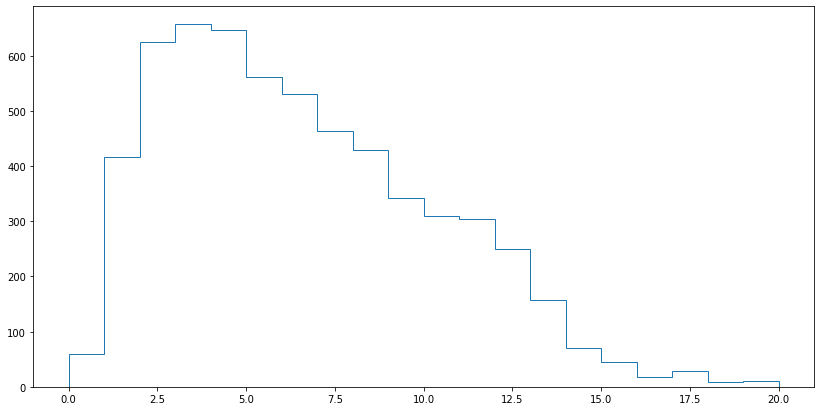

In [5]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

In [6]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

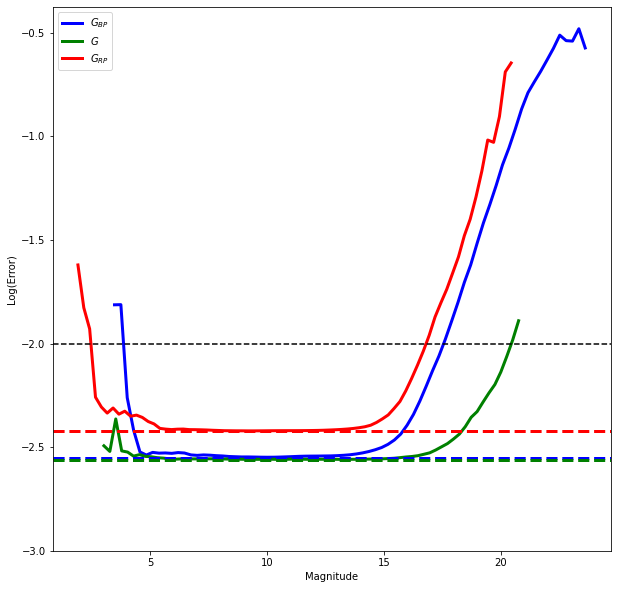

In [7]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.axhline(np.log10(0.0027901700),lw=3.0,c='blue',ls='--')
plt.axhline(np.log10(0.0027553202),lw=3.0,c='green',ls='--')
plt.axhline(np.log10(0.0037793818),lw=3.0,c='red',ls='--')
plt.axhline(np.log10(0.01),c='k',ls='--')
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');
# plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

In [8]:
allStar = Table(fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz'))
allStar = allStar['APOGEE_ID','FE_H','FE_H_ERR','J','H','K','J_ERR','H_ERR','K_ERR']

<ipython-input-10-95056c98c8ee>:24: RuntimeWarning: divide by zero encountered in log10
  hmaherr = np.log10(allStar['H_ERR'][h_fin])


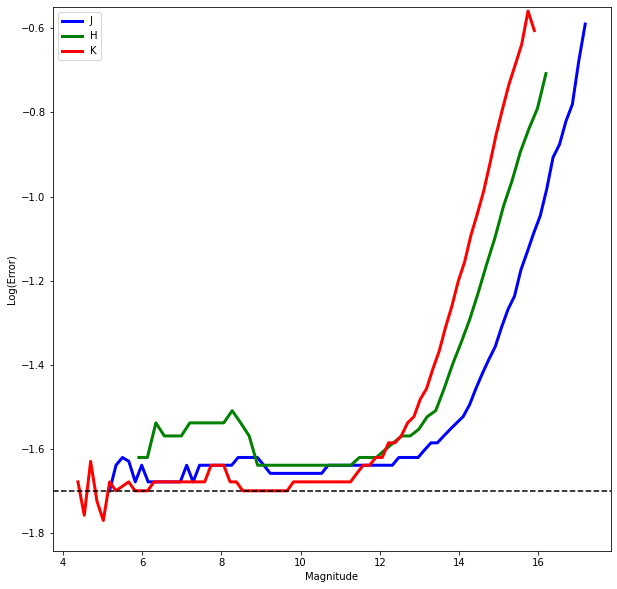

In [10]:
binnum = 75

### J
j_fin = np.where((np.isfinite(allStar['J'])==True)&(allStar['J']<50.)&
                 (np.isfinite(allStar['J_ERR'])==True)&(allStar['J_ERR']<1.))

jmin = min(allStar['J'][j_fin])
jmax = max(allStar['J'][j_fin])

jdiff = jmax-jmin
jmaherr = np.log10(allStar['J_ERR'][j_fin])

jbin ,_,_ = binned_statistic(allStar['J'][j_fin],jmaherr,'median',bins=binnum)
jerrfunc = bspline(np.arange(jmin,jmax,jdiff/binnum),jbin)

### H
h_fin = np.where((np.isfinite(allStar['H'])==True)&(allStar['H']<50.)&
                 (np.isfinite(allStar['H_ERR'])==True)&(allStar['H_ERR']<1.))

hmin = min(allStar['H'][h_fin])
hmax = max(allStar['H'][h_fin])

hdiff = hmax-hmin
hmaherr = np.log10(allStar['H_ERR'][h_fin])

hbin ,_,_ = binned_statistic(allStar['H'][h_fin],hmaherr,'median',bins=binnum)
herrfunc = bspline(np.arange(hmin,hmax,hdiff/binnum),hbin)

### K
k_fin = np.where((np.isfinite(allStar['K'])==True)&(allStar['K']<50.)&
                 (np.isfinite(allStar['K_ERR'])==True)&(allStar['K_ERR']<1.))

kmin = min(allStar['K'][k_fin])
kmax = max(allStar['K'][k_fin])

kdiff = kmax-kmin
kmaherr = np.log10(allStar['K_ERR'][k_fin])

kbin ,_,_ = binned_statistic(allStar['K'][k_fin],kmaherr,'median',bins=binnum)
kerrfunc = bspline(np.arange(kmin,kmax,kdiff/binnum),kbin)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(jmin,jmax,jdiff/binnum),jbin,lw=3.0,c='blue',label=r'J')
plt.plot(np.arange(hmin,hmax,hdiff/binnum),hbin,lw=3.0,c='green',label=r'H')
plt.plot(np.arange(kmin,kmax,kdiff/binnum),kbin,lw=3.0,c='red',label=r'K')
plt.legend()
plt.axhline(np.log10(0.02),c='k',ls='--')
plt.ylim(top=-0.55)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/2masserrorcurve.pdf',dpi=300,bbox_inches='tight');

### Calculate Errors for NaNs
jerr = 999999.0*np.ones(len(kdr17))
herr = 999999.0*np.ones(len(kdr17))
kerr = 999999.0*np.ones(len(kdr17))

for i in range(len(kdr17)):
    if np.isfinite(kdr17['J_ERR'][i])==False:
        jerr[i] = 10**jerrfunc(kdr17['J'][i])
    else:
        jerr[i] = kdr17['J_ERR'][i]
        
    if np.isfinite(kdr17['H_ERR'][i])==False:
        herr[i] = 10**herrfunc(kdr17['H'][i])
    else:
        herr[i] = kdr17['H_ERR'][i]
        
    if np.isfinite(kdr17['K_ERR'][i])==False:
        kerr[i] = 10**kerrfunc(kdr17['K'][i])
    else:
        kerr[i] = kdr17['K_ERR'][i]
        
### Replace nan's with zeropoint error
jerr = np.nan_to_num(jerr,nan=0.02)
herr = np.nan_to_num(herr,nan=0.02)
kerr = np.nan_to_num(kerr,nan=0.02)

In [12]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(kdr17['FPARAM'][:,0])+kdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(kdr17['FPARAM'][:,3])+tcorr

In [1]:
massive['MH']

NameError: name 'massive' is not defined

# Calculate Extinctions, Ages, and Masses

In [16]:
# lite = np.arange(len(kdr17))[::12]

kasc_ext = 999999.0*np.ones((len(kdr17),6))
kasc_ext_err = 999999.0*np.ones((len(kdr17),6))
kasc_age = 999999.0*np.ones(len(kdr17))
kasc_chi = 999999.0*np.ones(len(kdr17))
kasc_rms = 999999.0*np.ones(len(kdr17))
kasc_mass = 999999.0*np.ones(len(kdr17))

for i in tqdm(range(len(kdr17))):
    
    # Initialize Aetas 
    te = np.array([teff_cal[i],kdr17['TEFF_ERR'][i]])
    
    lg = np.array([kdr17['LOGG'][i],kdr17['LOGG_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],kdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],jerr[i],
                    herr[i],kerr[i]]]).T
    
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,lg,ab,op,di,massive,teff_extrap_limit=200)
    
    exts = CalcAge.extinction()
    kasc_ext[i,:],kasc_ext_err[i,:] = exts[:,0],exts[:,1]
    kasc_age[i],kasc_chi[i],kasc_rms[i] = CalcAge.get_age()
    kasc_mass[i] = CalcAge.age_2_mass(kasc_age[i])

  0%|          | 0/6099 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-15-f8a0bbbb0b55>:435: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:630: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = NX.asarray(y) + 0.0
<ipython-input-15-f8a0bbbb0b55>:435: RuntimeWarning: divide by zero encountered in log10
  lgage = np.log10(age*10**9)
<ipython-input-15-f8a0bbbb0b55>:104: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


<ipython-input-11-e9fec680f55f>:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


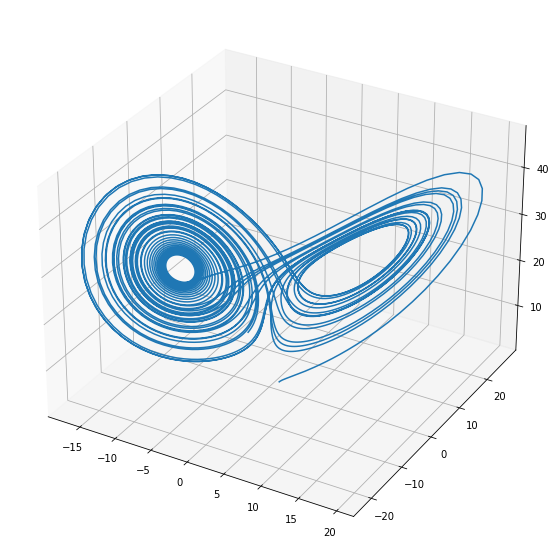

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [17]:
# import pdb

parsec_age = 999999.0*np.ones(len(kdr17))

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        teff: teff
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    test = np.where((isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
#     pdb.set_trace()
    
    idx_lo = np.where((isochrones['MH']==feh_lo)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_lo = isochrones[idx_lo]
    
    idx_hi = np.where((isochrones['MH']==feh_hi)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_hi = isochrones[idx_hi]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],kdr17['TEFF'][i],massive)

  0%|          | 0/6099 [00:00<?, ?it/s]

In [16]:
from astropy.table import Table, Column

cname = Column(kdr17['APOGEE_ID'], name='NAME')

cext = Column(kasc_ext,name='EXT')
cext_err = Column(kasc_ext_err,name='EXT_ERR')

cage = Column(kasc_age,name='AGE')
cchi = Column(kasc_chi,name='AGE_CHI')
crms = Column(kasc_rms,name='AGE_RMSE')

cpage = Column(parsec_age,name='PARSEC_AGE')

cmass = Column(kasc_mass,name='MASS')

cjage = Column(k674['A3P_AGEMOD_JT'],name='A3P_AGE_JAMIE')
cjmass = Column(k674['APOKASC3P_MASS'],name='A3P_MASS_JAMIE')

agetable = Table([cname,cext,cext_err,cage,cchi,crms,cpage,cmass,cjage,cjmass])
agetable.write('apokasc_lm_calteff_19SEP2022.fits',format='fits', overwrite=True)

In [17]:
agetab = fits.getdata('apokasc_lm_calteff_19SEP2022.fits')

In [ ]:
plt.figure(figsize=[12,10])
xmax = 18
ymax = 25
nbins = 50

age2age_fincut = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
                         (np.isfinite(agetab['PARSEC_AGE'])==True)&
                         (agetab['PARSEC_AGE']<100.))

age2age_ret = binned_statistic_2d(agetab['PARSEC_AGE'],agetab['AGE'],
                                  agetab['PARSEC_AGE'],'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/nbins)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,21],[0,21],lw=2.5,c='k')
# plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
# plt.plot([0,17.25],[4,17.25+4],lw=2.5,c='k')
# plt.plot([0,10.95],[11,11],lw=2.5,c='k')

# plt.plot([11,11],[0,5.5],c='k',lw=2.5)
# plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

xshift = 10
yshift = 10
plt.text(6+xshift,7+yshift,'y = x',rotation=45)
# plt.text(8+xshift,4.8+yshift,'y = x - 4',rotation=45)
# plt.text(4+xshift,8.8+yshift,'y = x + 4',rotation=45)
# plt.text(0.75,11.3,'y = 11')


plt.xlim(0,21)
plt.ylim(0,21)

plt.xticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))
plt.yticks(np.arange(0,21)[::2],np.arange(0,21)[::2].astype('str'))

plt.title(r'Calibrated Teff; Color as Number')
plt.xlabel(r'APOKASC Masses+PARSEC Models Age')
plt.ylabel(r'Photometric Matching Age')

plt.savefig('kasc_age2age_calteff.png',bbox_inches='tight')
plt.show()

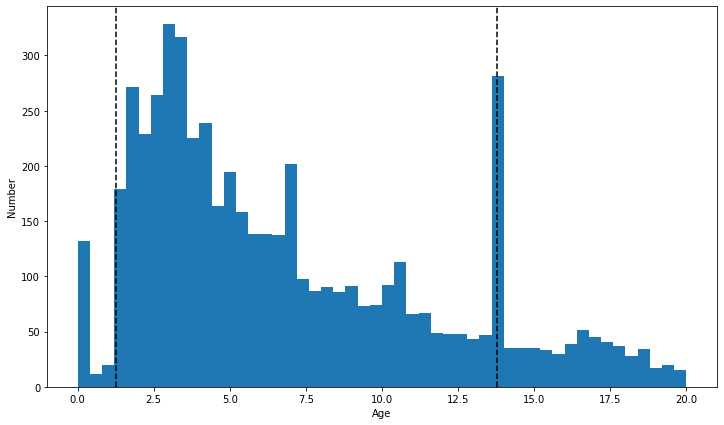

In [27]:
# plt.figure(figsize=[12,7])
# plt.hist(agetab['AGE'],range=(0,20),bins=50)
# plt.axvline(1.25,c='k',ls='--')
# plt.axvline(13.787,c='k',ls='--')
# plt.xlabel(r'Age')
# plt.ylabel(r'Number')
# # plt.savefig('lmc_lm_calteff_age_hist_lite.png',bbox_inches='tight')
# plt.show()

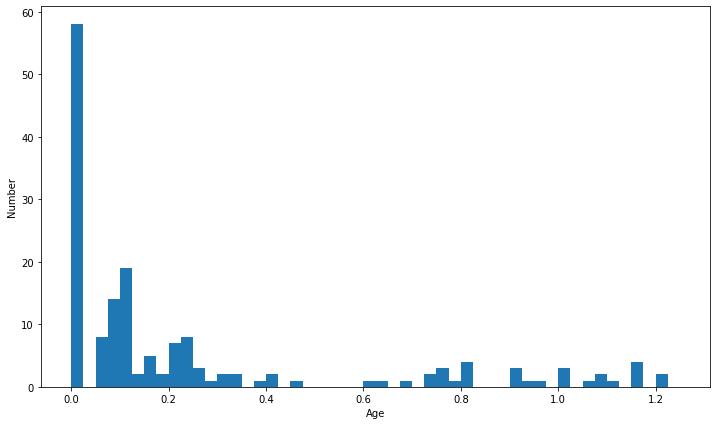

In [19]:
plt.figure(figsize=[12,7])
plt.hist(agetab['AGE'],range=(0,1.25),bins=50)
plt.xlabel(r'Age')
plt.ylabel(r'Number')
# plt.savefig('young1000.png',bbox_inches='tight')
plt.show()

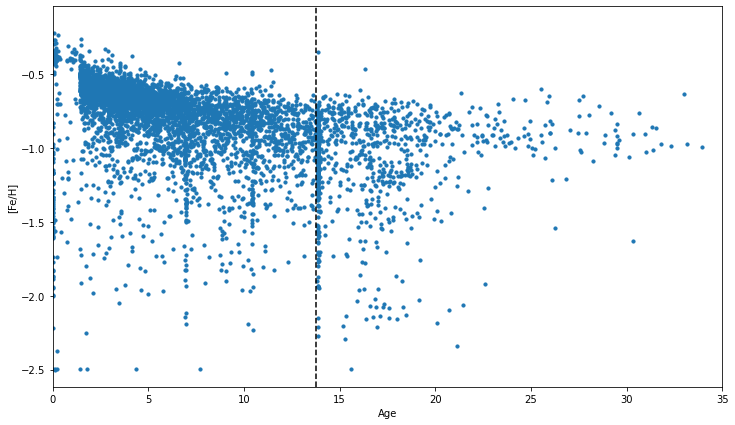

In [21]:
plt.figure(figsize=[12,7])
plt.scatter(agetab['AGE'],lmcdr17['FE_H'],s=10)
plt.axvline(13.787,c='k',ls='--')
plt.xlim(0,35)
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
# plt.savefig('lmc_lm_calteff_age_feh_lite.png',bbox_inches='tight')
plt.show()

In [24]:
np.where(agetab['AGE']==np.min(agetab['AGE']))

(array([4796]),)

In [30]:
# plt.plot(agetab['EXT'][agetab['AGE']==np.min(agetab['AGE'])][:,1])
# plt.ylim(0,2)

In [31]:
len(np.squeeze(np.where(agetab['EXT'][:,1]==999999.0)))

259

(0.0, 20.0)

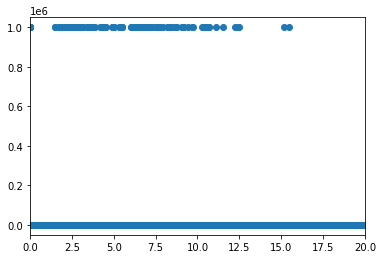

In [25]:
plt.scatter(agetab['AGE'],agetab['EXT'][:,1])
plt.xlim(0,20)

<ipython-input-26-ac6e0e3b0ab0>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  lmcdr17['LOGG'][[agetab['AGE']==np.min(agetab['AGE'])]])


Text(0, 0.5, 'LOGG')

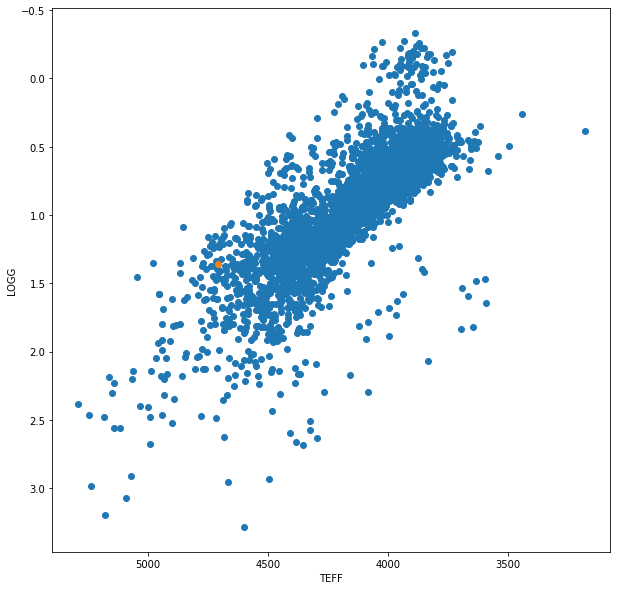

In [26]:
plt.figure(figsize=[10,10])
plt.scatter(lmcdr17['TEFF'],lmcdr17['LOGG'])
plt.scatter(lmcdr17['TEFF'][agetab['AGE']==np.min(agetab['AGE'])],
            lmcdr17['LOGG'][[agetab['AGE']==np.min(agetab['AGE'])]])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')

(array([3., 0., 0., 0., 0., 0., 0., 0., 1., 2.]),
 array([-2.0047   , -1.91907  , -1.83344  , -1.7478099, -1.66218  ,
        -1.57655  , -1.49092  , -1.4052899, -1.31966  , -1.23403  ,
        -1.1484   ], dtype=float32),
 <BarContainer object of 10 artists>)

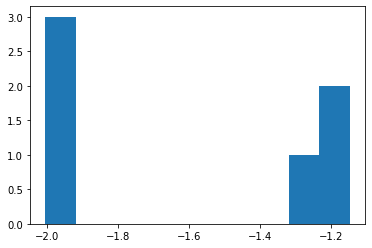

In [47]:
plt.hist(lmcdr17['FE_H'][lite][agetab['AGE']==np.min(agetab['AGE'])])

In [48]:
len(np.squeeze(np.where(agetab['AGE']==np.min(agetab['AGE']))))

6

# Single Star Debug

In [49]:
agetab['NAME'][agetab['AGE']==np.min(agetab['AGE'])]

chararray(['2M05183243-7317520', '2M04523621-7103493',
           '2M05030562-7146005', '2M06393584-7024151',
           '2M05320309-6547358', '2M05393664-6607254'], dtype='<U18')

In [60]:
star = np.where(lmcdr17['APOGEE_ID']=='2M05393664-6607254')

In [61]:
star_ext = 999999.0*np.ones(6)
star_ext_err = 999999.0*np.ones(6)
star_age = 999999.0
star_chi = 999999.0
star_rms = 999999.0
star_mass = 999999.0
    
# Initialize Aetas 
te = np.array([teff_cal[star],lmcdr17['TEFF_ERR'][star]])

lg = np.array([lmcdr17['LOGG'][star],lmcdr17['LOGG_ERR'][star]])

ab = np.array([lmcdr17['FE_H'][star],apoafe[star],
               lmcdr17['FE_H_ERR'][star],apoafe_err[star]]).reshape((2,2)).T

new_j_err = np.nan_to_num(10**bperrfunc(lmcdr17['J_ERR'][star]),nan=0.02)
new_h_err = np.nan_to_num(10**bperrfunc(lmcdr17['H_ERR'][star]),nan=0.02)
new_k_err = np.nan_to_num(10**bperrfunc(lmcdr17['K_ERR'][star]),nan=0.02)

op = np.array([lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][star],
               lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][star],
               lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][star],
               lmcdr17['J'][star],lmcdr17['H'][star],lmcdr17['K'][star],
               bperr[star],gerr[star],rperr[star],jerr[star],
               herr[star],kerr[star]]).reshape((2,6)).T

di = lmcdis[i]*1000

CalcAge = Aetas(te,lg,ab,op,di,massive,debug=True)
    
exts = CalcAge.extinction()
star_ext,star_ext_err = exts[:,0],exts[:,1]
star_age,star_chi,stra_rms = CalcAge.get_age()
star_mass = CalcAge.age_2_mass(star_age)

### Running Aetas.extinction() ###
Inputs from Aetas.__init__()
Salaris Corrected Metallicity: -1.390262513505493
Temperature: [3751.91916914]
Calculated Observed Colors:
Observed Colors: [1.12190056 1.04479885 2.45629883 3.31329918 3.4812994 ]
Observed Color Errors: [0.00805072 0.00515977 0.0241671  0.02020021 0.02714864]
Isochrone Colors: [0.8836015  0.9191831  2.14916794 2.94760524 3.09548893]
A(G)+ Error: 0.47730251520204475 0.03402511066218061
All Extinctions: [0.58145868 0.47730252 0.36755141 0.16352844 0.10358428 0.06566887]
chisq: 288.2214533833418
resid: [ 0.13414289  0.01586465 -0.00664319 -0.00802429 -0.02582318]
Running Aetas.get_age()
guess_ages: [1.20000000e-02 3.47893878e+00 6.94587755e+00 1.04128163e+01
 1.38797551e+01]
Running Aetas.teff_2_appmags()
Teff: [3751.91916914]
Extinctions: [0.58145868 0.47730252 0.36755141 0.16352844 0.10358428 0.06566887]
[age_lo,age_hi]:  [0.02499999950079735, 0.07499978182030029]
outside iso_lo
Age 0.02499999950079735
max iso_lo 3.6661
mi

In [31]:
star_mass

999999.0

In [32]:
op

array([[1.66268997e+01, 5.48655954e-03],
       [1.56956997e+01, 2.81911153e-03],
       [1.47447996e+01, 4.14763699e-03],
       [1.34420004e+01, 2.89999992e-02],
       [1.27060003e+01, 2.99999993e-02],
       [1.25570002e+01, 3.29999998e-02]])

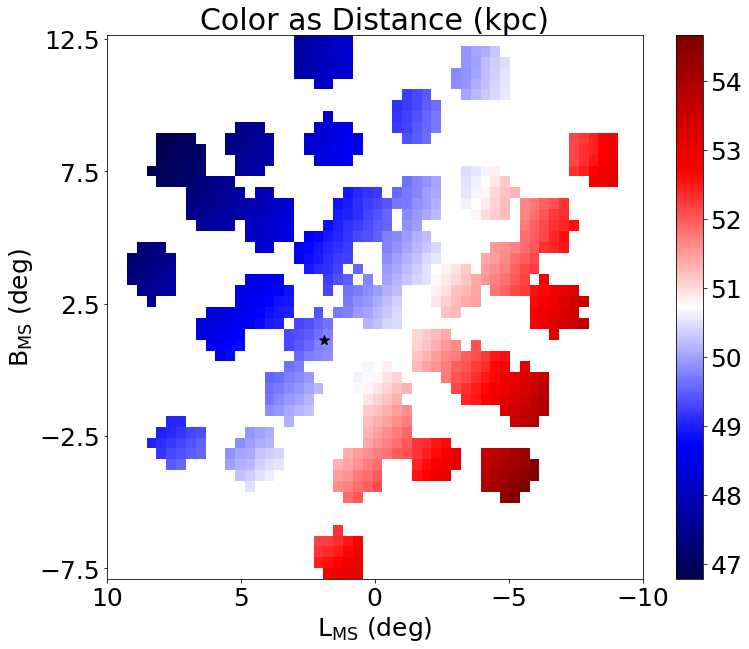

In [95]:
#######
plt.figure(figsize=[12,10])
ret = binned_statistic_2d(lms_lmc,bms_lmc,lmcdis,'median',bins=50)
im = plt.imshow(ret.statistic.T, origin='lower',
                    extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
                    aspect='auto',interpolation='nearest',cmap='seismic')
plt.gca().invert_xaxis()
plt.colorbar()

plt.scatter(lms_lmc[star],bms_lmc[star],marker='*',s=100,c='k')

plt.xticks([10,5,0,-5,-10])
plt.yticks([-7.5,-2.5,2.5,7.5,12.5])

plt.title(r'Color as Distance (kpc)')
plt.xlabel(r'${\rm L_{MS}}$ (deg)')
plt.ylabel(r'${\rm B_{MS}}$ (deg)')
# plt.savefig('../plots/lmc_map_MSdistance.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [97]:
lmcdr17['FIELD'][star]

chararray(['LMC14'], dtype='<U5')

In [100]:
lmcdr17['K_ERR'][::6][agetab['AGE']==np.min(agetab['AGE'])]

array([  nan, 0.023, 0.03 , 0.033, 0.029, 0.03 , 0.026, 0.027, 0.03 ,
       0.03 , 0.03 , 0.03 , 0.026, 0.027, 0.034, 0.033, 0.024, 0.03 ,
       0.027, 0.027, 0.033, 0.028,   nan, 0.026, 0.026, 0.023, 0.026,
       0.025, 0.025, 0.023, 0.024, 0.027, 0.028, 0.026, 0.023, 0.024,
       0.021, 0.027, 0.023, 0.024], dtype=float32)

In [102]:
len(np.squeeze(np.where(gerr<0.01)))

6130

In [108]:
test = np.array([1,2,4,np.nan])

np.size(np.where(np.isfinite(test)==False))

1

In [113]:
if np.size(np.where(np.isfinite(test)==False))>0:
    raise ValueError

ValueError: 